# How can one hear the shape of a quantum drum?

## Analyze example 1: Two-qubit J coupling Hamiltonian

Method: stochastic estimation

Hamiltonian:

$H = \frac{J}{2} \left( \begin{array}{cccc} 1 & 0 & 0 & 0 \\
                                                   0 & -1 & 0 & 0 \\
                                                   0 & 0 & -1 & 0 \\
                                                   0 & 0 & 0 & 1 \end{array} \right)$
                                                   
Measurement result $k$ is obtained with probability $p_k$:

$  p_k = \langle k| \left[ M_1\otimes M_0 \right] e^{-iHt} \left[ U_1\otimes U_0 \right] |0\rangle $

In [20]:
import itertools
import sympy
import numpy as np
import scipy.linalg
import scipy.stats
import tensorflow  as  tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload
from sympy.physics.quantum.dagger import Dagger

In [21]:
# global configuration flags
from absl import app
from absl import flags
reload(flags)
FLAGS = flags.FLAGS

if "verbose" not in dir(FLAGS):
  flags.DEFINE_boolean('verbose', True, "generate verbose debugging output")
  flags.DEFINE_boolean('limit_search_space', False, "truncate MLE search space")
  
FLAGS(['verbose'])

['verbose']

## 1. Define Nature

Nature knows the Hamiltonian $H$,
and provides to Physicist a set of measurement observation results
${\cal O}$, in response to a query ${\cal Q} = \{ \cal M, U, C \}$
from the Physicist, comprises measurement observables ${\cal M}$,
initial state preparation operators ${\cal U}$, and control parameters
${\cal C}$.

In [22]:
class Nature(object):
  '''
  Represent Nature's knowledge of the (hidden) model Hamiltonian, providing
  a method to obtain sample measurement observable results.
  '''  
  
  def __init__(self, J):
    '''
    J = qubit coupling strength (known to Nature, not to Physicist)
    '''
    self.J = J
    self.ZZ = np.matrix([[1,0,0,0],
                          [0,-1,0,0],
                          [0,0,-1,0],
                          [0,0,0,1]])
    self.hmat = self.ZZ * self.J/2
    self.basis = np.matrix(np.eye(4))   # basis vectors |0>, |1>, |2>, |3>
    self.psi0 = self.basis[:,0]         # |0>
  
  @staticmethod
  def kron(a,b):
    return np.matrix(scipy.linalg.kron(a,b))
    
  def sample_measurement_observable(self, observables, preparation, control, 
                                    nsamples=10, return_probabilities=False,
                                    return_state=False, return_symbolic=False): 
    '''
    observables = [M1, M0]
    preparation = [U1, U0]
    control = array of times
    '''
    u10 = self.kron(*preparation)
    m10 = self.kron(*observables)
    samples = []
    kvals = range(4)
    psi_in = u10 * self.psi0
      
    if return_symbolic:
      J, t = sympy.symbols("J t", real=True)
      psi = (sympy.Matrix(m10) * sympy.exp(-1j * sympy.Matrix(self.ZZ) * J * t / 2) 
             * sympy.Matrix(psi_in))
      pvec = [0] * 4
      for k in range(4):
        c = psi[k,0]
        pvec[k] = (sympy.conjugate(c) * c).expand().simplify()
      return {'psi': psi, 'probabilities': pvec}
    
    for t in control:
      if FLAGS.verbose:
        print("[Nature.sample] t=%s" % t)
      uevol = scipy.linalg.expm(-1j * self.hmat * t)
      psi = m10 * uevol * psi_in
      
      pvec = abs(np.array(psi.T)[0,:])**2
      if FLAGS.verbose:
        print("[Nature.sample] psi=%s" % psi.T)
      if return_state:          # immediately return (for first control value)
        return psi
      if return_probabilities:
        return pvec
    
      pdf = scipy.stats.rv_discrete(name="psi", values=(kvals, pvec))
      samples.append(pdf.rvs(size=nsamples))
      
    return np.array(samples)

### Check one instance of mother nature

In [23]:
mn = Nature(J=0.3)
hadamard = np.matrix([[1,1],[1,-1]])/np.sqrt(2)
si = np.matrix(np.eye(2))
observables = [hadamard, si]
preparation = [hadamard, si]
pvec = mn.sample_measurement_observable(observables, preparation, [0.04], return_probabilities=True)
assert abs(pvec.sum() - 1.0) < 1.0e-4
print("probabilities = \n%s" % pvec)

probabilities = 
[9.9996400e-01 0.0000000e+00 3.5999568e-05 0.0000000e+00]


In [24]:
formulas = mn.sample_measurement_observable(observables, preparation, [], return_symbolic=True)
print("symbolic probabilities = \n%s" % formulas['probabilities'])

symbolic probabilities = 
[0.5*cos(1.0*J*t) + 0.5, 0, -0.5*cos(1.0*J*t) + 0.5, 0]


### Plot $p_0$ vs time

Should get a sinusoid

In [25]:
FLAGS.verbose = False
tvec = np.linspace(0, 100, 200)
pvec = [ mn.sample_measurement_observable(observables, preparation, [t], 
                                          return_probabilities=True)[0] for t in tvec ]

In [26]:
# compute value expected from symbolic formula
Jval = 0.3
svec = 0.5 * np.cos(Jval * tvec) + 0.5

Text(0.5,1,'Test of J-coupling Model: p_0 vs time ')

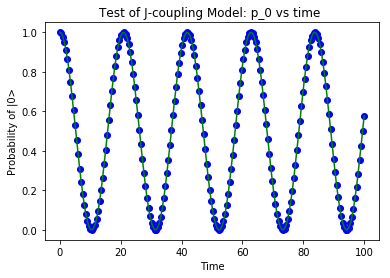

In [27]:
plt.plot(tvec,pvec, 'bo')
plt.plot(tvec,svec, 'g-')
plt.xlabel("Time")
plt.ylabel("Probability of |0>")
plt.title("Test of J-coupling Model: p_0 vs time ")

### Plot discrete probability distribution and test sampling

In [28]:
kvals = range(4)
pk = mn.sample_measurement_observable(observables, preparation, [5], return_probabilities=True)
pdf = scipy.stats.rv_discrete(name="psi", values=(kvals, pk))

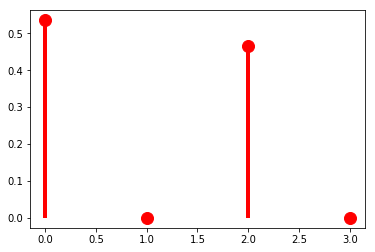

In [29]:
plt.plot(kvals, pdf.pmf(kvals), 'ro', ms=12, mec='r')
plt.vlines(kvals, 0, pdf.pmf(kvals), colors='r', lw=4)

In [30]:
pdf.rvs(size=10)

array([2, 2, 2, 2, 2, 2, 2, 0, 2, 2])

In [31]:
samples = mn.sample_measurement_observable(observables, preparation, [5], nsamples=10)
assert samples.size==10
samples

array([[0, 0, 0, 2, 2, 2, 0, 0, 2, 0]])

#### Test sampling

In [32]:
nt = 400
ns = 20
tvec = np.linspace(0, 20, nt)
samples = mn.sample_measurement_observable(observables, preparation, tvec, nsamples=ns)
assert(samples.shape==(nt,ns))

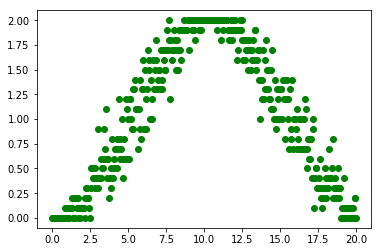

In [33]:
plt.plot(tvec, samples.mean(axis=1), 'go')

### Make dataset for stochastic estimation

In [34]:
def make_dataset(tmax, nsamples, J=0.3, do_plot=False):
  '''
  Construct and return randomly samples from Nature's model,
  with randomly chosen times in the interval [0, tmax).
  
  Return vector of times and samples.
  
  Each sample is an integer in the interval [0, 3]
  '''
  mn = Nature(J)
  tvec = np.random.random(size=nsamples) * tmax
  svec = mn.sample_measurement_observable(observables, preparation, tvec, 
                                          nsamples=1).reshape([-1])
  if do_plot:
    plt.scatter(data['time'], data['samples'])
    plt.grid(True)
    plt.xlabel("time")
    plt.ylabel("measurement result")
    plt.title("Dataset with %s samples at random times (J=%s)" % (nsamples, J))
  return {'time': tvec, 
          'samples': svec,
          'J': J,               # for ground-truth comparison
         }

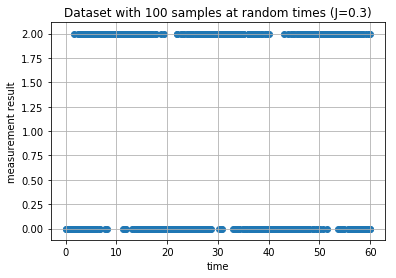

In [35]:
data = make_dataset(60, 100, do_plot=True)

## 2. Check maximum likelihood behavior

In [36]:
def test_max_likelihood(data, npts=400, jmin=0.2, jmax=0.4, do_plot=True):
  ybin = data['samples'] / 2.0
  print("Computing negative max likelihood on dataset with %d samples" % ybin.size)
  jvec = np.linspace(jmin, jmax, npts)
  print("Sampling %d values of J from %s to %s" % (jvec.size, jvec.min(), jvec.max()))
  xvec = data['time']
  llvec = []
  for j in jvec:
    ysp = 0.5*np.cos(j * xvec) + 0.5
    ll = np.log( ybin * ysp + (1-ybin) * (1-ysp) + 1.0e-8) 
    llvec.append( ll.mean() )
  llvec = np.array(llvec)
  if do_plot:
    plt.plot(jvec, llvec)
    plt.grid(True)
    plt.xlabel("J")
    plt.ylabel("negative log likelihood")
    plt.title("Dataset with %d samples" % ybin.size)
  return jvec, llvec

Computing negative max likelihood on dataset with 1000 samples
Sampling 800 values of J from 0.1 to 0.6


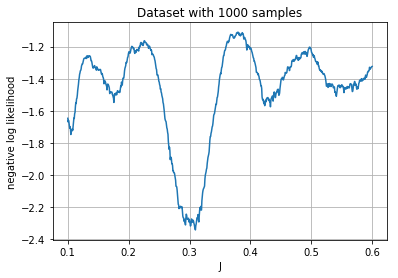

In [37]:
data = make_dataset(60, 1000, do_plot=False)
jvec, llvec = test_max_likelihood(data, 800, 0.1, 0.6)

## 3. Build stochastic estimation model

In [38]:
def estimation_model(data, nepochs=2, neval_period=10, 
                     learning_rate=0.001, optimizer="gd",
                     mini_batch_size=512,
                     init_J=0.5, verbose=True, do_plot=True):
  '''
  Tensorflow model of sinusoid evolution, with J as the latent variable.
  
  Runs maximum likelihood fitting, returns J.
  
  data = dict with data
  nepochs = number of "epochs" of fitting, where each epoch goes through all the data
  
  This version uses minibatching, to allow randomness to encourage jumps out of
  shallow local minima.
  '''
  print("Model training for %s epochs, with evaluation every %s steps" % (nepochs, 
                                                                          neval_period))
  samples = np.array(data['samples']).astype(np.float32)  
  tpts = np.array(data['time']).astype(np.float32)  
  batch_size = len(tpts)
  
  xy = np.stack([tpts, samples], axis=1)
  print("Input data xy shape=%s" % str(xy.shape))
  n_mini_batches = int(xy.shape[0] / mini_batch_size)
  print("Each epoch has %d mini_batches of size %s" % (n_mini_batches, mini_batch_size))  
  print("Input data shapes samples=%s, tpts=%s" % (samples.shape, tpts.shape))
  
  # graph input
  X = tf.placeholder(tf.float32, name="X_time_points")
  Y = tf.placeholder(tf.float32, name="Y_samples")        # y = 0 or 2
  print("Input data placeholders X=%s, Y=%s" % (X, Y))
  
  # model variables
  if FLAGS.limit_search_space:
    init_pre_J = np.arctanh( (init_J - 0.2)/0.15 )    # use nonlinear mapping
    J_check = np.tanh(init_pre_J) * 0.15 + 0.2        # to truncate search space
    pre_J = tf.Variable(init_pre_J, name="J", dtype=tf.float32)
    J = tf.tanh(pre_J)*0.15 + 0.2        # J is in 0.2 +/- 0.15
    print("initial values: J=%s (init_pre_J=%s, J_check=%s)" % (init_J, init_pre_J, 
                                                                J_check))
  else:
    J = tf.Variable(init_J, name="J", dtype=tf.float32)
    print("initial values: J=%s" % (init_J,))
  
  # model to predict sample probability (prob(k=0))
  Y_sp = 0.5*tf.cos(J * X) + 0.5
  
  # loss function (binary cross-entropy)
  Ybin = Y / 2.0  # 0 or 1
  loss = tf.log( Ybin * Y_sp + (1-Ybin) * (1-Y_sp) + 1.0e-8)   # log likelihood
  loss = tf.reduce_mean(loss)  # take mean over batch
  
  # optimizer
  if optimizer=="gd":
    gdo = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer_op = gdo.minimize(loss)
    op_name = "GD"
  elif optimizer=="adagrad":
    optimizer_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
    op_name = "Adagrad"
  else:
    optimizer_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    op_name = "Adam"
  print("Using %s optimmizer, learning rate=%s" % (op_name, learning_rate))
  
  losses = []    # record losses at each epoch step
  steps = []
  
  # run MLE
  if verbose:
    print("Running MLE over %s datapoints with %s epochs" % (batch_size, nepochs))
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for k in range(nepochs):
      np.random.shuffle(xy)     # random in-place permutation of first dimension
      for n in range(n_mini_batches):
        n0 = n*mini_batch_size
        sess.run(optimizer_op, feed_dict={X:xy[n0:n0+mini_batch_size, 0], 
                                          Y:xy[n0:n0+mini_batch_size, 1]})      

      if not (k % neval_period):
        results = sess.run([loss, J], feed_dict={X:tpts, Y:samples})
        print("    Epoch %s: loss=%s, J=%s" % tuple([k] + results))
        losses.append(results[0])
        steps.append(k)
        if np.isnan(results[0]):
          raise Exception("loss is NaN, quitting!")
  
    results = sess.run([loss, J], feed_dict={X:tpts, Y:samples})
    
  m_loss, m_J = results
  if verbose:
    print("Results from ML regression: loss=%s, J=%s" % (m_loss, m_J))
    if 'J' in data:
      rmse = np.sqrt((m_J - data['J'])**2)
      print("Actual J=%s, rmse=%s" % (data['J'], rmse))
  
  if do_plot:
    plt.plot(steps, losses, 'go')
    plt.plot(steps, losses)
    plt.grid(True)
    plt.xlabel("Epoch step number")
    plt.ylabel("Loss (negative log likelihood)")
    plt.suptitle("Tensorflow MLE on dataset with %s samples using %s optimizer" % 
              (samples.size, op_name))
    plt.title("Final J=%5.4f, RMSE=%5.4f" % (m_J, rmse))
  
  return {'losses': losses,
         'steps': steps,
         'results': results}
  

## 4. Run Maximum Likelihood Estimation (using tensorflow)

In [39]:
# make dataset
data = make_dataset(60, 1000, J=0.3)

Computing negative max likelihood on dataset with 1000 samples
Sampling 800 values of J from 0.1 to 0.6


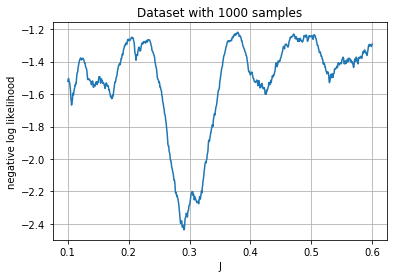

In [40]:
jvec, llvec = test_max_likelihood(data, 800, 0.1, 0.6)

Model training for 4000 epochs, with evaluation every 80 steps
Input data xy shape=(1000, 2)
Each epoch has 5 mini_batches of size 200
Input data shapes samples=(1000,), tpts=(1000,)
Input data placeholders X=Tensor("X_time_points:0", dtype=float32), Y=Tensor("Y_samples:0", dtype=float32)
initial values: J=0.35
Using Adam optimmizer, learning rate=0.0001
Running MLE over 1000 datapoints with 4000 epochs
    Epoch 0: loss=-1.5195179, J=0.3497647
    Epoch 80: loss=-1.5737689, J=0.34772748
    Epoch 160: loss=-1.722185, J=0.34174076
    Epoch 240: loss=-1.7839041, J=0.3373573
    Epoch 320: loss=-1.8211919, J=0.33570176
    Epoch 400: loss=-1.8733652, J=0.33304662
    Epoch 480: loss=-1.8829826, J=0.3327216
    Epoch 560: loss=-1.8851019, J=0.33206272
    Epoch 640: loss=-1.937705, J=0.33048293
    Epoch 720: loss=-2.0048025, J=0.3280571
    Epoch 800: loss=-2.0305488, J=0.32553276
    Epoch 880: loss=-2.1088035, J=0.3231581
    Epoch 960: loss=-2.1228368, J=0.32264727
    Epoch 1040: lo

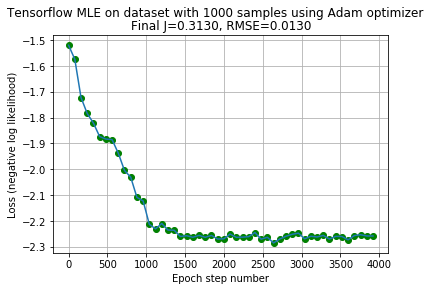

In [41]:
# run MLE, with initial J different from actual J (and see how fast it converges)
res = estimation_model(data, 4000, neval_period=80,
                          init_J=0.35, mini_batch_size=200,
                          learning_rate=0.0001, optimizer="adam")

Model training for 8000 epochs, with evaluation every 80 steps
Input data xy shape=(1000, 2)
Each epoch has 10 mini_batches of size 100
Input data shapes samples=(1000,), tpts=(1000,)
Input data placeholders X=Tensor("X_time_points_1:0", dtype=float32), Y=Tensor("Y_samples_1:0", dtype=float32)
initial values: J=0.28
Using Adam optimmizer, learning rate=0.0001
Running MLE over 1000 datapoints with 8000 epochs
    Epoch 0: loss=-2.2411284, J=0.2801922
    Epoch 80: loss=-2.3809893, J=0.28700495
    Epoch 160: loss=-2.3874483, J=0.28727546
    Epoch 240: loss=-2.404504, J=0.28908005
    Epoch 320: loss=-2.4138465, J=0.29047
    Epoch 400: loss=-2.4098856, J=0.2918243
    Epoch 480: loss=-2.427895, J=0.29033735
    Epoch 560: loss=-2.422963, J=0.29167688
    Epoch 640: loss=-2.4271858, J=0.29152298
    Epoch 720: loss=-2.354146, J=0.2930822
    Epoch 800: loss=-2.3819392, J=0.2923985
    Epoch 880: loss=-2.4378648, J=0.29084823
    Epoch 960: loss=-2.3714063, J=0.29251596
    Epoch 1040: l

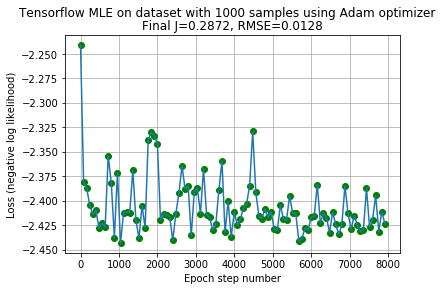

In [42]:
res = estimation_model(data, 8000, neval_period=80,
                          init_J=0.28, mini_batch_size=100,
                          learning_rate=0.0001, optimizer="adam")

## Analyze ML peak as a function of dataset size

Computing negative max likelihood on dataset with 10 samples
Sampling 800 values of J from 0.1 to 0.6


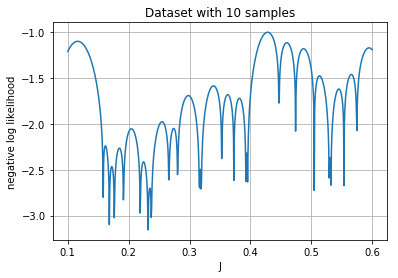

Computing negative max likelihood on dataset with 50 samples
Sampling 800 values of J from 0.1 to 0.6


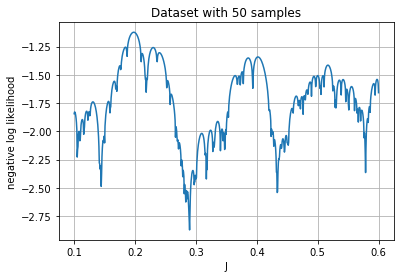

Computing negative max likelihood on dataset with 100 samples
Sampling 800 values of J from 0.1 to 0.6


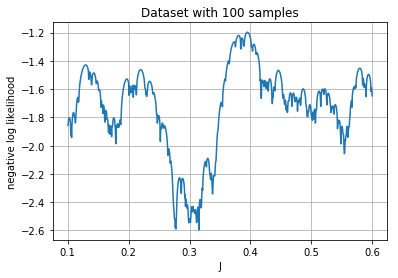

Computing negative max likelihood on dataset with 1000 samples
Sampling 800 values of J from 0.1 to 0.6


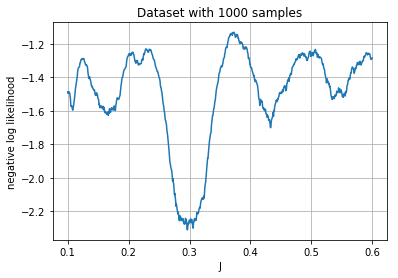

Computing negative max likelihood on dataset with 2000 samples
Sampling 800 values of J from 0.1 to 0.6


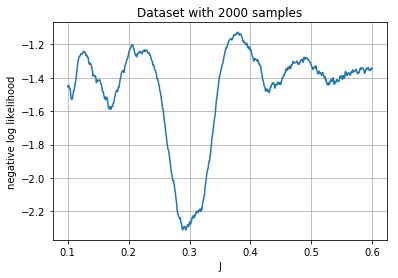

Computing negative max likelihood on dataset with 4000 samples
Sampling 800 values of J from 0.1 to 0.6


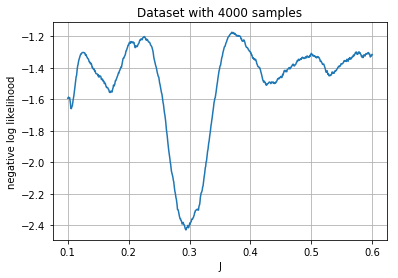

In [138]:
for nsamples in [10, 50, 100, 1000, 2000, 4000]:
  data = make_dataset(60, nsamples, do_plot=False)
  jvec, llvec = test_max_likelihood(data, 800, 0.1, 0.6)
  plt.show()